In [1]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
df = pd.read_csv("/kaggle/input/final-train-data/training_data.csv")

In [4]:
df.head()

,ID,article_link,text,label
0,4724,https://www.huffingtonpost.com/entry/trump-rea...,"how trump really feels about queer people, exp...",0
1,26559,https://www.huffingtonpost.com/entry/egyptian-...,egyptian death sentence for soccer fans puts p...,0
2,24613,https://www.theonion.com/stripper-failing-scho...,stripper failing school she's working self thr...,1
3,9048,https://www.huffingtonpost.com/entry/ken-paxto...,texas attorney general ken paxton indicted,0
4,69,https://www.huffingtonpost.com/entry/debbie-di...,congresswoman fights for gun control because s...,0


In [5]:
type(df.dtypes['label'])

numpy.dtypes.Int64DType

In [6]:
# df =df[(df['label']=='0') | (df['label']=='1')]
# df['label'] = df['label'].astype(int)

In [7]:
df.columns

Index(['ID', 'article_link', 'text', 'label'], dtype='object')

In [8]:
df['label'] = df[df.columns[3]].values.tolist()
new_df = df[['text', 'label']].copy()
new_df.head()

,text,label
0,"how trump really feels about queer people, exp...",0
1,egyptian death sentence for soccer fans puts p...,0
2,stripper failing school she's working self thr...,1
3,texas attorney general ken paxton indicted,0
4,congresswoman fights for gun control because s...,0


In [9]:
new_df.shape

(22895, 2)

In [10]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
train_df, valid_df = train_test_split(new_df, test_size=0.3, random_state=42)

In [12]:
# Training

In [13]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe['text']
        self.targets = self.data["label"]
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [14]:
# Creating the dataset and dataloader for the neural network

valid_size = 1
valid_dataset=valid_df.sample(frac=valid_size,random_state=200)
# test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
valid_dataset = valid_dataset.reset_index(drop=True)


# print("FULL Dataset: {}".format(new_df.shape))
# print("TRAIN Dataset: {}".format(train_dataset.shape))
# # print("TEST Dataset: {}".format(test_dataset.shape))

valid_set = CustomDataset(valid_dataset, tokenizer, MAX_LEN)
# testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

In [15]:
# Creating the dataset and dataloader for the neural network

train_size = 1
train_dataset=train_df.sample(frac=train_size,random_state=200)
# test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


# print("FULL Dataset: {}".format(new_df.shape))
# print("TRAIN Dataset: {}".format(train_dataset.shape))
# # print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
# testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

In [16]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                'drop_last': True 
                }

training_loader = DataLoader(training_set, **train_params)

In [17]:
valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                'drop_last': True 
                }

valid_loader = DataLoader(valid_set, **valid_params)

In [18]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 1)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output


In [19]:
model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [20]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(epoch):
    model.train()
    curr_loss = 0
    for batch_num,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float).reshape(TRAIN_BATCH_SIZE,-1)
#         print(targets.shape)
        outputs = model(ids, mask, token_type_ids)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        curr_loss+=loss.data.item()
#         print(curr_loss)
#         if batch_num%512==0:
#             print(f'Epoch: {epoch}, Batch_num: {batch_num}, Loss: {loss.item()}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         break
    
    return curr_loss/(len(training_loader)*TRAIN_BATCH_SIZE)

In [ ]:
cost = []
EPOCHS = 15
for epoch in range(EPOCHS):
    loss = train(epoch)
    print(f'Epoch: {epoch} Loss: {loss}')
    cost.append(loss)

In [ ]:
# model_path = "model_bert3.pth"
# torch.save(model, model_path)

In [ ]:
torch.save(model.state_dict(), "model_bert_nlp.pth")

In [ ]:
df_cost = pd.DataFrame({'Cost': cost})
csv_file_path = '/kaggle/working/cost_list.csv'
df_cost.to_csv(csv_file_path, index=False)

In [ ]:
plt.plot(np.arange(0,len(cost)),cost)
plt.show()
plot_path = "/kaggle/working/cost_plot.png"
plt.savefig(plot_path)

In [20]:
model = torch.load("/kaggle/input/nlp-bert/model_bert.pth", map_location=torch.device('cpu'))
device = 'cuda' if cuda.is_available() else 'cpu'

In [29]:
def validation():
    model.eval()
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        for i, data in tqdm(enumerate(valid_loader, 0)):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            if i % 100 == 0:
                print(i)
    return fin_outputs, fin_targets

# Move model to device
model.to(device)


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [37]:
outputs, targets = validation()

0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
1it [00:00,  2.24it/s]

0


101it [00:43,  2.34it/s]

100


107it [00:45,  2.33it/s]


Confusion Matrix =
[[3344  219]
 [ 301 2984]]
AUROC Score = 0.97650445919951


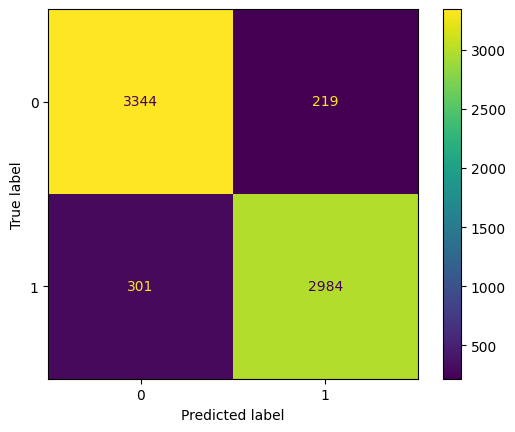

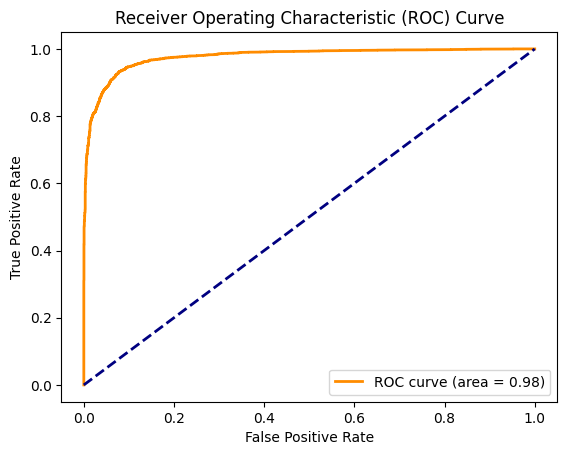

Accuracy Score = 0.9240654205607477
Classication metrics:
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      3563
         1.0       0.93      0.91      0.92      3285

    accuracy                           0.92      6848
   macro avg       0.92      0.92      0.92      6848
weighted avg       0.92      0.92      0.92      6848

F1 Score (Micro) = 0.9240654205607477
F1 Score (Macro) = 0.9238549850761792


In [42]:
outputs_bin = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs_bin)
f1_score_micro = metrics.f1_score(targets, outputs_bin, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs_bin, average='macro')
classication_metrics = metrics.classification_report(targets, outputs_bin)
cm = metrics.confusion_matrix(targets, outputs_bin)
print("Confusion Matrix =")
print(cm)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot()
# plt.show()
plt.savefig('confusion_matrix.png')

# Calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(targets, outputs)

# Calculate AUROC score
auroc_score = metrics.roc_auc_score(targets, outputs)

# Print AUROC score
print(f"AUROC Score = {auroc_score}")

# Plot ROC curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auroc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('bert_auroc_plot.png')
plt.show()

print(f"Accuracy Score = {accuracy}")
print("Classication metrics:")
print(classication_metrics)
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")